----
<h1 align="center"><span style='font-family:Georgia'> G-Research Cryptocurrency Forecasting </span></h1>

---

### Proplem Statement
To Evaluate the model, historical cryptocurrency dataset is utilized with the objective of constructing time series forecasting models. A time series analysis is carried out to extract information from the entire dataset and preprocess the data by incorporating additional features. Subsequently, an ARIMA model is selected as the traditional baseline model. Several neural network time series models, including DLinear, NLinear, Informer, FEDformer, and PatchTST, are then assessed on the data to examine their forecasting performance in comparison to the ARIMA baseline.
> This work aims to identify the best approach for 15-minute ahead forecasting of the cryptocurrency log return (Target column) over the next 15 minutes.

### Dataset Description

- **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
- **Asset_ID**: TThis column contains an ID number that corresponds to a specific cryptocurrency. For example, an Asset_ID of 1 corresponds to Bitcoin. A mapping from Asset_ID to the name of the cryptocurrency can be found in a separate file called `asset_details.csv`.
- **Count**: Total number of trades in the time interval (last minute).
- **Open**: Opening price of the time interval (in USD).
- **High**: Highest price reached during time interval (in USD).
- **Low**: Lowest price reached during time interval (in USD).
- **Close**: Closing price of the time interval (in USD).
- **Volume**: The quantity of the cryptocurrency that was bought or sold during the minute of trading activity represented by the corresponding timestamp, measured in USD.
- **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
- **Target**: This column contains the residual log-returns for the cryptocurrency over a 15-minute horizon. Residual log-returns are a way of measuring the percentage change in the price of an asset over a given time period, relative to some baseline. The Target column in this dataset represents the residual log-returns for a 15-minute period starting from the minute represented by the corresponding timestamp.

Additional information about cryptocurrencies include:

- **Asset_ID** : An ID code for the cryptocurrency.
- **Asse_Name** : The real name of the cryptocurrency associated to Asset_ID.
- **Weight** : The weight that the cryptocurrency associated to Asset_ID receives in the evaluation metric.

#### **The Evaluation Criteria**

- **MAE (Mean Absolute Error)** - The average magnitude of the errors in the predictions and gives an idea of the accuracy of the predictions.
- **MAPE (Mean Absolute Percentage Error)** - The average magnitude of the percentage error, useful to nullify the effect of different scales in values.
- **MSE (Mean Squared Error)** - The average of the square of the errors. MSE is more sensitive to large errors compared to MAE.

**So in summary, a good model will have:**
- Low MAE, MAPE and MSE

---
## Notebook Content
The notebook focuses on time series analysis and forecasting using various traditional and transformer-based models. The content of the notebook is organized into several sections:

### (1) Check Data Quality.
### (2) Time Series Analysis.

- Data Distribution.
- Candlestick Chart.
- Stationarity.
- Simple Moving Average (SMA).
- Exponential Smoothing.
- Average True Range (ATR).
- Seasonal and Trend Decomposition.
- ACF and PACF.

### (3) Feature Engineering
- Technical Indicators Features (RSI, ATR, and DEMA).
- Lag Features Features ( SMA and Return).
- New Price-based Features (HL, OC, Lower Shadow, and Upper Shadow).
- Datetime Features (Day, dayofyear, Season).

### (4) Create cryptoh1 dataset (aggregated from the 1 min period dataset).

### (5) Modeling Hourly Cryptocurrancy Dataset
- Choosing ARIMA as a basline model from the traditional models.
- Evaluating the dataset DLinear
- Evaluating the dataset NLinear
- Evaluating the dataset Informer
- Evaluating the dataset FEDfromer
- Evaluating the dataset PathchTST

### (6) Analysis the Results

---
# Setup
---

In [1]:
# !pip install opendatasets

In [3]:
# !pip install torchscan 

  Using cached torchscan-0.1.2-py3-none-any.whl (30 kB)
  Using cached torch-1.13.1-cp39-cp39-manylinux1_x86_64.whl (887.4 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is incompatible.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.13.1 which is inco

In [29]:
# !pip install mplfinance 

In [2]:
# !pip install pmdarima

  Using cached pmdarima-2.0.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (1.9 MB)


**Import needed dependencies**

In [1]:
import os
import time
import pandas as pd
import numpy as np
import random
import itertools
from tqdm import tqdm
import pmdarima as pm
import matplotlib.dates as mdates
import opendatasets as od 

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

# statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
import statsmodels.tsa.api as smt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error 

import torch

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Allocate color palette**

In [1]:
plt.style.use('seaborn-white')
%matplotlib inline

RdBu_colors  = sns.color_palette("RdBu",15)
pastel_colors  = sns.color_palette("pastel",15)
blind_colors = sns.color_palette("colorblind", 15)
sns.set_theme(style="whitegrid", palette=RdBu_colors)

style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 10});
fig = mpf.figure(figsize=(18, 5), style=style);
    
RdBu_colors
pastel_colors
blind_colors

[(0.5884659746251442, 0.05905420991926182, 0.1510957324106113),
 (0.7340253748558246, 0.16608996539792387, 0.20261437908496732),
 (0.8226066897347174, 0.34325259515570933, 0.28627450980392155),
 (0.8991926182237601, 0.5144175317185697, 0.4079200307574009),
 (0.9617070357554787, 0.6761245674740484, 0.546943483275663),
 (0.9838523644752019, 0.8089965397923875, 0.7167243367935409),
 (0.9829296424452134, 0.9018838908112264, 0.8542099192618224),
 (0.9657054978854287, 0.9672433679354094, 0.9680891964628989),
 (0.8722029988465976, 0.9229527104959632, 0.9508650519031142),
 (0.7517877739331029, 0.8635909265667053, 0.9217993079584775),
 (0.5967704728950406, 0.7848519800076895, 0.8775086505190313),
 (0.4085351787773935, 0.6687427912341408, 0.8145328719723184),
 (0.24183006535947713, 0.5487889273356401, 0.750557477893118),
 (0.15816993464052287, 0.43806228373702427, 0.6939638600538255),
 (0.08419838523644753, 0.31280276816609, 0.5534025374855824)]

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353),
 (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0)]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

<Mpf_Figure size 1800x500 with 0 Axes>

In [2]:
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

**Download dataset from kaggle**
You may need to upload kaggle token file from dir: `./Datasets/CustomData/kaggle.json`.
- username:"hebamo7amed"
- key:"dc5470313c833c4962ebace8898816fa"

In [4]:
od.download("https://www.kaggle.com/competitions/g-research-crypto-forecasting/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  hebamo7amed


Your Kaggle Key:

  ································


100%|██████████| 1.13G/1.13G [00:53<00:00, 22.7MB/s]



Extracting archive ./g-research-crypto-forecasting/g-research-crypto-forecasting.zip to ./g-research-crypto-forecasting


**Helper Functions**

In [3]:
def reduce_memory(df):
    
    before = df.memory_usage().sum()  
    
    for col in df.columns:        
        dtype = df[col].dtype
        if dtype == 'float64':
            c_min = df[col].min()
            c_max = df[col].max()        
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)    
                    
    after = df.memory_usage().sum()
    
    print('Memory taken before transformation : ', before)
    print('Memory taken after transformation : ', after)
    print('Memory taken reduced by : ',( before - after) * 100/ before, '%')
    
    return df

In [4]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
        
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [5]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
                A higher alpha value gives more weight to recent observations, 
                making the smoothed values more responsive to recent changes in the data.
    """
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    values = series.values
    result = [values[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * values[n] + (1 - alpha) * result[n-1])
    return result

In [6]:
def MovingAveragePlot(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False,figsize=(18,5)):
    
    """
    df - dataframe with timeseries
    column_name - name of column to analyze (choose 1 at a time)
    window - rolling window size 
    plot_intervals - show confidence intervals
    plot_anomalies - show anomalies 

    """

    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=figsize)
    plt.plot(series.index, series,color=RdBu_colors[0], label="Actual values", lw=1.5)
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.fill_between(rolling_mean.index, lower_bound, upper_bound, color='lightgrey', alpha=0.5, label=f'Confidence Interval (scale={scale})')

        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.Series(index=series.index, name=series.name)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, color=RdBu_colors[0], marker=".",alpha=0.5, markersize=10, label = 'Spiks')
            
    
    
    plt.title("Moving average\n window size = {}".format(window), fontsize=14)
    plt.plot(rolling_mean, color=RdBu_colors[-1], lw=2, label="Rolling mean trend",)
    plt.xlabel('Time', fontsize=12)
    plt.legend(loc='best', fontsize=9)    
    plt.grid(False)
    plt.show()

In [7]:
def ExponentialSmoothingPlot(series, alphas, plot_intervals = False, scale = 1.96, plot_anomalies=False, figsize=(18, 5)):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """  
    plt.figure(figsize=figsize)
    plt.plot(series.values, color=blind_colors[-5], label = "Actual", lw=1.5)
    for i, alpha in enumerate(alphas):
        
        plt.plot(exponential_smoothing(series, alpha),'--', lw=1, color=blind_colors[-(i+2)], label="Alpha {}".format(alpha))
    
    plt.title("Exponential Smoothing", fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend(loc='best', fontsize=9)    
    plt.grid(False)
    plt.show()

In [8]:
def check_stationarity(series, signif=0.05, name='', verbose=False):
    

    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [9]:
def ACF_PACF(y, lags=None, figsize=(9, 6), name=None):
    """
        Plot time series, its ACF and PACF, calculate Dickey-Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    plt.rcParams.update({'font.size': 8})
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(f'{name} Dickey-Fuller: p={p_value:.5f} with lag={lags}'.title())
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()

In [10]:
def PlotDecomposation(series, result):
    
    fig, axes = plt.subplots(4, 1, figsize=(25, 12), sharex= True);

    series.plot(lw = 2.5, ax=axes[0],color=blind_colors[0], legend=False);
    result.trend.resample('Q').mean().plot(lw = 2.5,ax=axes[1], color=blind_colors[1] , legend=False);
    result.seasonal.resample('W').mean().plot(lw = 2.5, ax=axes[2], color=blind_colors[2], legend=False);
    result.resid.plot(lw=0, marker='o', alpha = 0.6, markersize=5, ax=axes[3],color=RdBu_colors[0], legend=False);

    axes[0].set_ylabel('Original', fontsize=14);
    axes[1].set_ylabel('Trend Monthly', fontsize=14);
    axes[2].set_ylabel('Seasonal Weakly', fontsize=14);
    axes[3].set_ylabel('Residual', fontsize=14);
    
    fig.suptitle(f'Seasonal and Trend Decomposition'.title(), fontsize=20);
    plt.xlabel('Date',fontsize = 14)
    plt.show()

In [11]:
def ATR(df, n):
    tmp = np.maximum(
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift()),
        np.abs(df['Low'] - df['Close'].shift())
    )

    return tmp.rolling(window=n, min_periods=1).mean()

def RSI(df, n):
    
    delta = df['Close'].diff()
    gain = delta.mask(delta < 0, 0)
    loss = -delta.mask(delta > 0, 0)
    avg_gain = gain.rolling(window=n, min_periods=1).mean()
    avg_loss = loss.rolling(window=n, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

#Create a function to calculate the Double Exponential Moving Average (DEMA)
def DEMA(data, time_period):
    #Calculate the Exponential Moving Average for some time_period (in days)
    EMA = data['Close'].ewm(span=time_period, adjust=False).mean()
    #Calculate the DEMA
    DEMA = 2*EMA - EMA.ewm(span=time_period, adjust=False).mean()
    return DEMA

def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

---
# Load Datasets
---

In [12]:
%%time
crypto_df = pd.read_csv(r'./Datasets/CustomData/train.csv', parse_dates=True) 
crypto_df.head()

CPU times: user 17.9 s, sys: 1.78 s, total: 19.7 s
Wall time: 19.7 s


timestamp  Asset_ID    Count        Open        High         Low   
0  1514764860         2  40.0000  2,376.5800  2,399.5000  2,357.1400  \
1  1514764860         0   5.0000      8.5300      8.5300      8.5300   
2  1514764860         1 229.0000 13,835.1940 14,013.8000 13,666.1100   
3  1514764860         5  32.0000      7.6596      7.6596      7.6567   
4  1514764860         7   5.0000     25.9200     25.9200     25.8740   

        Close     Volume        VWAP  Target  
0  2,374.5900    19.2330  2,373.1164 -0.0042  
1      8.5300    78.3800      8.5300 -0.0144  
2 13,850.1760    31.5501 13,827.0621 -0.0146  
3      7.6576 6,626.7134      7.6577 -0.0139  
4     25.8770   121.0873     25.8914 -0.0083

**Assets**
In the list of transactions, assets are referred to by Asset_ID. Let's look into asset_details.csv to see what these 'assets' are.

In [13]:
asset_details = pd.read_csv(r'./Datasets/CustomData/asset_details.csv')
asset_details.head()

Asset_ID  Weight        Asset_Name
0         2  2.3979      Bitcoin Cash
1         0  4.3041      Binance Coin
2         1  6.7799           Bitcoin
3         5  1.3863            EOS.IO
4         7  2.0794  Ethereum Classic

In [14]:
asset_names = asset_details.Asset_Name.unique()

for index in range(0,14):
    crypto_df['Asset_ID'].replace({index : asset_names[index]}, inplace=True)

crypto_df.rename(columns={'Asset_ID':'Asset_Name'}, inplace=True)
crypto_df.head(5)

timestamp    Asset_Name    Count        Open        High         Low   
0  1514764860       Bitcoin  40.0000  2,376.5800  2,399.5000  2,357.1400  \
1  1514764860  Bitcoin Cash   5.0000      8.5300      8.5300      8.5300   
2  1514764860  Binance Coin 229.0000 13,835.1940 14,013.8000 13,666.1100   
3  1514764860      Ethereum  32.0000      7.6596      7.6596      7.6567   
4  1514764860        Monero   5.0000     25.9200     25.9200     25.8740   

        Close     Volume        VWAP  Target  
0  2,374.5900    19.2330  2,373.1164 -0.0042  
1      8.5300    78.3800      8.5300 -0.0144  
2 13,850.1760    31.5501 13,827.0621 -0.0146  
3      7.6576 6,626.7134      7.6577 -0.0139  
4     25.8770   121.0873     25.8914 -0.0083

In [15]:
crypto_df = reduce_memory(crypto_df)

Memory taken before transformation :  1938944608
Memory taken after transformation :  1260314040
Memory taken reduced by :  34.99999768946468 %


---
# (1) Check Data Quality

---

In [20]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24236806 entries, 2018-01-01 00:01:00 to 2021-09-21 00:00:00
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   timestamp   int64  
 1   Asset_Name  object 
 2   Count       float32
 3   Open        float32
 4   High        float32
 5   Low         float32
 6   Close       float32
 7   Volume      float32
 8   VWAP        float64
 9   Target      float32
dtypes: float32(7), float64(1), int64(1), object(1)
memory usage: 1.4+ GB


**Check Missing Values**

In [17]:
crypto_df.isna().sum()

timestamp          0
Asset_Name         0
Count              0
Open               0
High               0
Low                0
Close              0
Volume             0
VWAP               9
Target        750338
dtype: int64

In [16]:
crypto_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
print(f"Missing Data Percentage:{crypto_df.isna().sum().sum()*100/ len(crypto_df):0.2f}%")

Missing Data Percentage:3.10%


In [17]:
crypto_df['Target'] = crypto_df['Target'].interpolate(method='linear')
crypto_df['VWAP'] = crypto_df['VWAP'].interpolate(method='linear')

print(f"Missing Data Percentage:{crypto_df.isna().sum().sum()*100/ len(crypto_df):0.2f}%")

Missing Data Percentage:0.00%


**Check Duplication**

In [75]:
print("There is no duplicated appointments record in this data set.") \
if not crypto_df.duplicated().sum() else crypto_df.duplicated().sum()  

There is no duplicated appointments record in this data set.


---
# (2) Time Series Analysis

---

### 1. Data Distribution
Visualize the data distribution of different assets, showing the number of rows (observations) associated with each asset. 

In [20]:
InteractiveShell.ast_node_interactivity = 'last_expr'

In [24]:
asset_count= []
for i in asset_names:
    count = (crypto_df["Asset_Name"]==i).sum()
    asset_count.append(count)

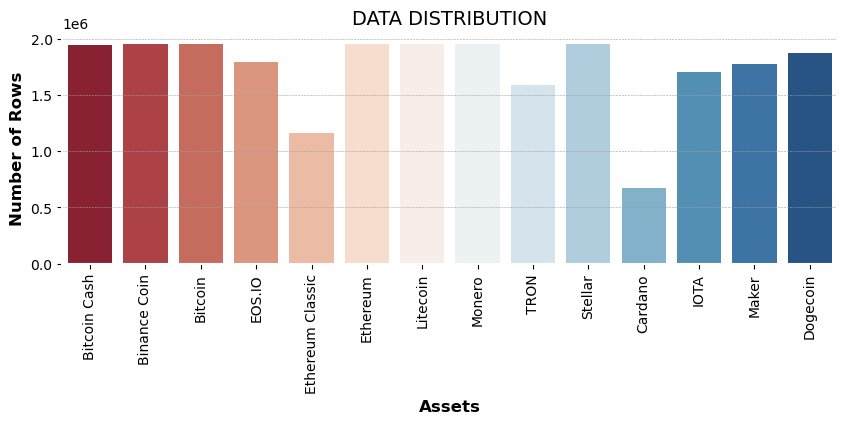

In [25]:
InteractiveShell.ast_node_interactivity = 'last_expr'
plt.figure(figsize=(10, 3))
bar_plot  = sns.barplot(x=asset_names, y=asset_count, palette='RdBu')

plt.title("Data Distribution".upper(), fontsize = 14)
plt.xlabel("Assets")
plt.ylabel("Number of Rows")
plt.xticks(rotation=90)  
plt.show()

In [21]:
crypto_df['date'] = pd.to_datetime(crypto_df['timestamp'], unit='s')
crypto_df = crypto_df.set_index('date')
crypto_df.head(5)

timestamp    Asset_Name    Count        Open   
date                                                                 
2018-01-01 00:01:00  1514764860       Bitcoin  40.0000  2,376.5801  \
2018-01-01 00:01:00  1514764860  Bitcoin Cash   5.0000      8.5300   
2018-01-01 00:01:00  1514764860  Binance Coin 229.0000 13,835.1943   
2018-01-01 00:01:00  1514764860      Ethereum  32.0000      7.6596   
2018-01-01 00:01:00  1514764860        Monero   5.0000     25.9200   

                           High         Low       Close     Volume   
date                                                                 
2018-01-01 00:01:00  2,399.5000  2,357.1399  2,374.5901    19.2330  \
2018-01-01 00:01:00      8.5300      8.5300      8.5300    78.3800   
2018-01-01 00:01:00 14,013.7998 13,666.1104 13,850.1758    31.5501   
2018-01-01 00:01:00      7.6596      7.6567      7.6576 6,626.7134   
2018-01-01 00:01:00     25.9200     25.8740     25.8770   121.0873   

                           VWAP  Target  
date                                     
2018-01-01 00:01:00  2,373.1164 -0.0042  
2018-01-01 00:01:00      8.5300 -0.0144  
2018-01-01 00:01:00 13,827.0621 -0.0146  
2018-01-01 00:01:00      7.6577 -0.0139  
2018-01-01 00:01:00     25.8914 -0.0083

**Number of sample for each asset per year?**

In [27]:
pd.crosstab(index=crypto_df.index.year, columns=crypto_df.Asset_Name)

Asset_Name  Binance Coin  Bitcoin  Bitcoin Cash  Cardano  Dogecoin  EOS.IO   
row_0                                                                        
2018              525588   524824        516254     3043    444248  372254  \
2019              524969   522998        521768    10440    524724  514334   
2020              527014   527008        526023   278773    526887  526570   
2021              378711   378707        378574   378241    378701  378709   

Asset_Name  Ethereum  Ethereum Classic    IOTA  Litecoin   Maker  Monero   
row_0                                                                      
2018          524538                 0  359861    525588  350276  523450  \
2019          524870            326093  462965    524894  523198  523106   
2020          527022            452065  499790    527010  526565  525865   
2021          378710            378708  378645    378708  378710  378706   

Asset_Name  Stellar    TRON  
row_0                        
2018         525587  336463  
2019         524720  446855  
2020         527014  430397  
2021         378709  378356

<a ><font size="2.5"><b>OBSERVATION:</b></font></a>
assets generally have a relatively consistent number of records across the four years of the dataset, with some minor fluctuations. But Dogecoin had no records in 2018

### 2. Candlestick Chart in Financial Data Visualization

For identifying trends, reversals, and patterns in asset prices, a candlestick chart represents the price movement of an asset over a specific time period, like a day, week, or month. 

**Components of a Candlestick**

Each candlestick has four main components:

1. Open Price (Open): The opening price of the asset at the beginning of the period.
2. High Price (High): The highest price the asset reached during the period.
3. Low Price (Low): The lowest price the asset reached during the period.
4. Close Price (Close): The closing price of the asset at the end of the period.

The body of the candlestick represents the price range between the opening and closing prices, while the vertical lines (shadows) extend from the top and bottom of the body to show the highest and lowest prices.

**Bullish and Bearish Candlesticks**

- If the *closing price is higher than the opening price*, the body is typically **green**, indicating a bullish (price increase) period.
- If the *closing price is lower than the opening price*, the body is typically **red**, indicating a bearish (price decrease) period.



**Price movement over week**

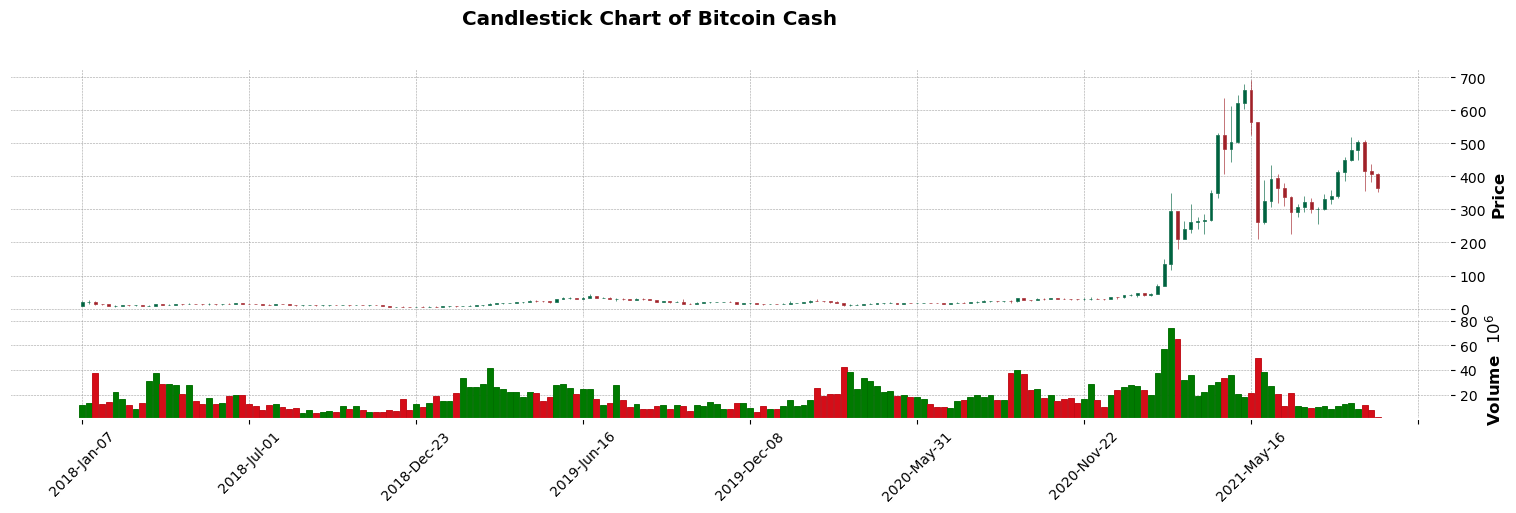

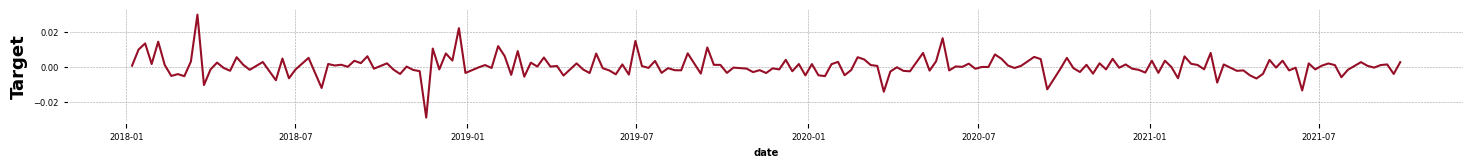

In [22]:
agg = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    'VWAP': 'mean',
    'Target':'last',
}

for i in asset_names:
    
    df = crypto_df[crypto_df["Asset_Name"]==i]
    df= df.resample('W').apply(agg)
    
    mpf.plot(df, type='candle', style='charles',  figsize=(20, 5), volume=True, title=f"Candlestick Chart of {i}", returnfig=True,);#addplot=VWAP;
    style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
    fig = mpf.figure(figsize=(18, 5), style=style)
    ax_target = fig.add_subplot(3, 1, 1)
    sns.lineplot(data=df, x=df.index, y='Target', ax=ax_target, color=RdBu_colors[0], linewidth=1.5);
    ax_target.set_ylabel('Target', fontsize=13)
    
    plt.show()
    break

## 3. Stationarity  
Stationarity refers to the statistical properties of a time series remaining constant over time, which means that the mean, variance, and autocorrelation structure do not change with time.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [38]:
check_stationarity(crypto_df['Target'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
ADF Statistic: -6.135612
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


## 4. Simple Moving Average (SMA)

The provided code includes a function named `MovingAveragePlot` which is used to plot the moving average for a given time series data. The function takes several parameters as input:

**Function Parameters:**

- `series`: The input time series data for which the moving average needs to be calculated and plotted.
- `window`: The rolling window size for the moving average. It determines the number of data points used to calculate the average.
- `plot_intervals`: A boolean flag indicating whether to plot confidence intervals around the smoothed values. If set to `True`, the function will plot upper and lower bounds for the moving average.
- `scale`: A scaling factor used to calculate the confidence intervals. The default value is 1.96, which corresponds to the 95% confidence interval.
- `plot_anomalies`: Another boolean flag indicating whether to highlight anomalies in the time series data. If set to `True`, the function will plot data points that fall outside the confidence intervals.

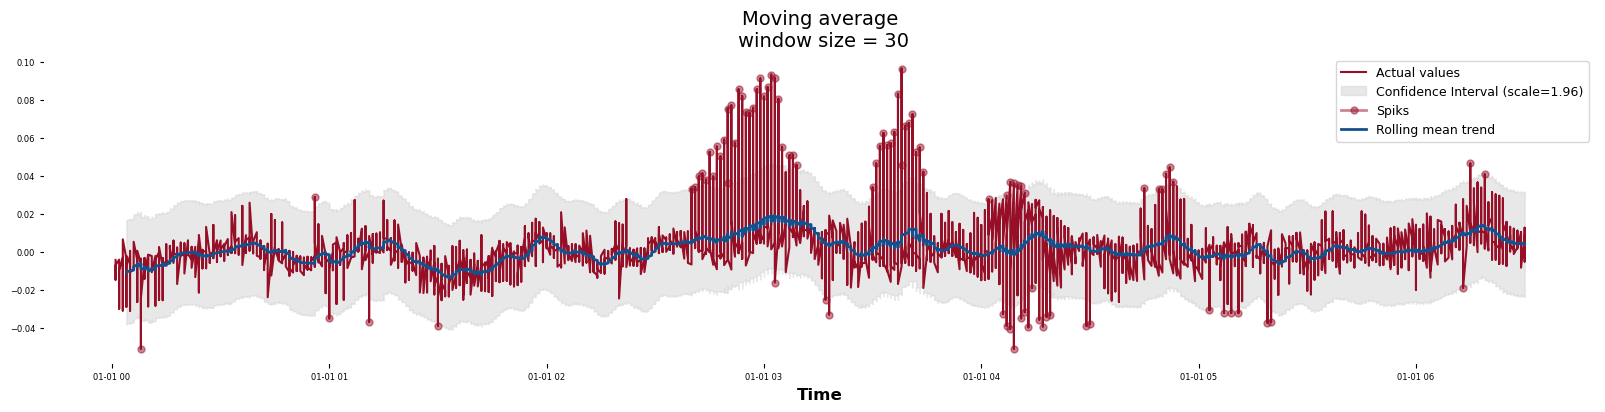

In [24]:
MovingAveragePlot(crypto_df.iloc[:3000, -1], window=30, plot_intervals=True, plot_anomalies=True, figsize=(20, 4))

**Moving average for Bitcoin asset**

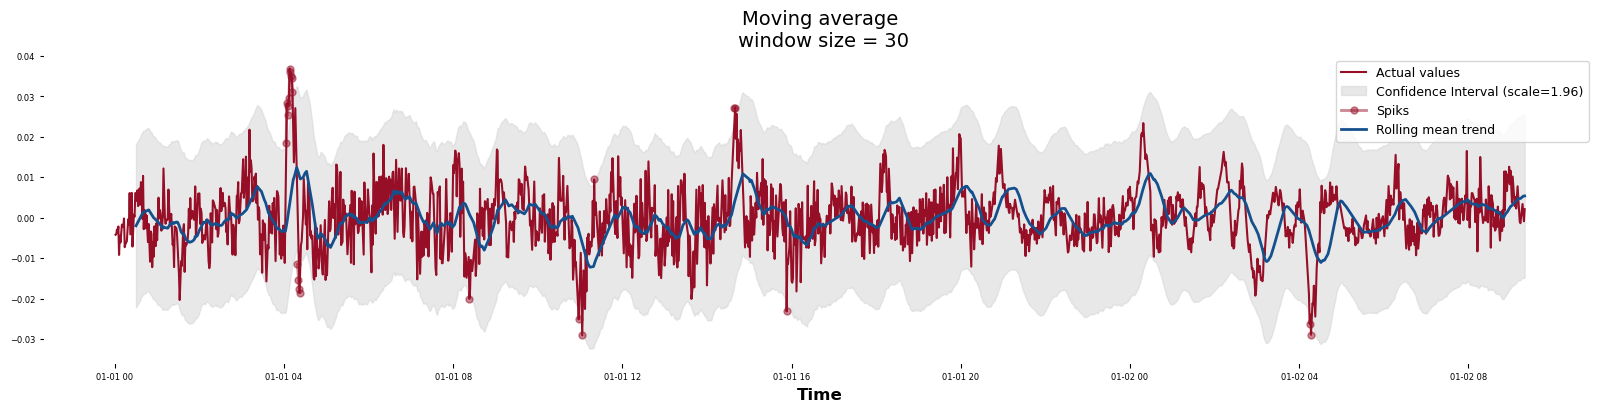

In [25]:
MovingAveragePlot(crypto_df[crypto_df.Asset_Name=='Bitcoin'].iloc[:2000,-1], window=30, plot_intervals=True, plot_anomalies=True, figsize=(20, 4))

## 5. Exponential Smoothing
Exponential smoothing is a popular method for forecasting time series data and smoothing out random variations to reveal underlying trends. It is particularly useful when the data is noisy or contains irregular fluctuations. It works by assigning exponentially decreasing weights to past observations, with more recent observations receiving higher weights than older ones.
$$F(t+1) = alpha * D(t) + (1 - alpha) * F(t)$$
- The value of alpha typically ranges between 0 and 1.
- Higher alpha values indicating more weight given to recent observations.

**Function Parameters:**
- `series`: The input time series data with timestamps for which exponential smoothing needs to be applied.
- `alphas`: A list of smoothing parameters that controls the weight of the current observation in the smoothing process. It should be a list of float values between 0 and 1.

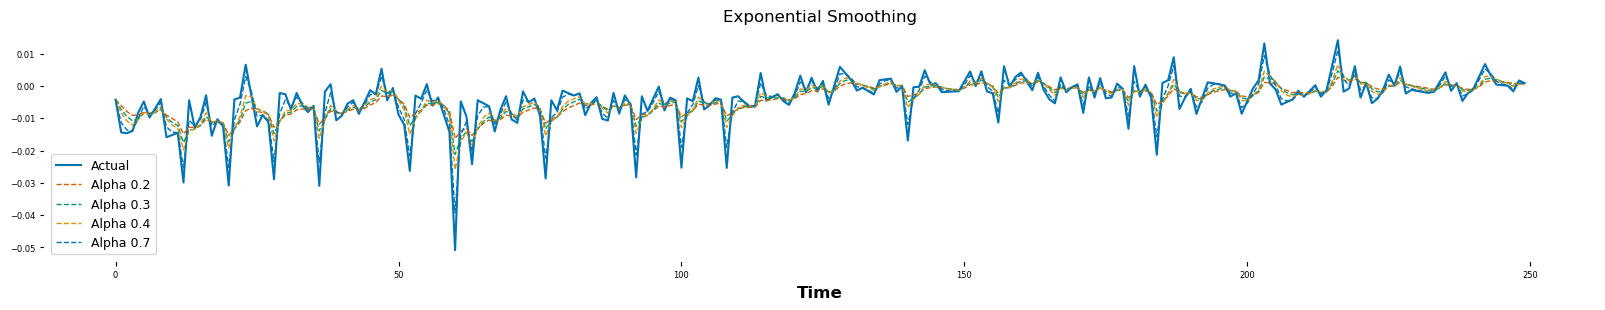

In [23]:
ExponentialSmoothingPlot(crypto_df.iloc[:250,-1], alphas=[0.2, 0.3, 0.4, 0.7],figsize=(20, 3)) #, plot_anomalies=True, plot_intervals=True, 

**Exponential smoothing for Bitcoin asset**

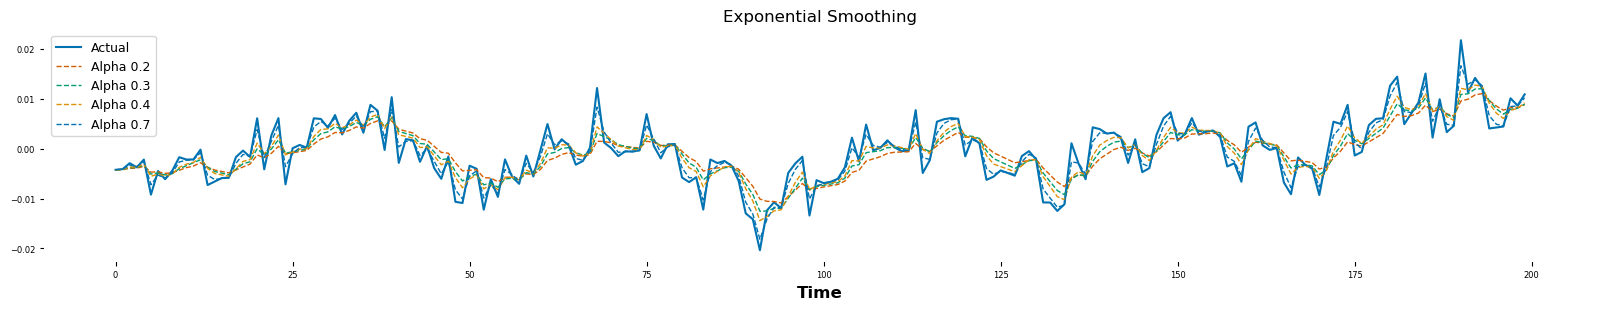

In [52]:
ExponentialSmoothingPlot(crypto_df[crypto_df.Asset_Name=='Bitcoin'].iloc[:200,-1], alphas=[0.2, 0.3, 0.4, 0.7],figsize=(20, 3)) #, plot_anomalies=True, plot_intervals=True, 

## 6. Average True Range (ATR)
The ATR indicator is based on the range of price movements (high to low) in a given period, taking into account any gaps that might occur between trading sessions. It calculates the average range over a specified number of periods, typically using a rolling or exponential moving average. A higher ATR value indicates greater volatility, while a lower value suggests lower volatility. 

**Calculate the True Range (TR) for each period:**
$$TR = Max[(High - Low), abs(High - Previous Close), abs(Low - Previous Close)]$$

- ATR = Rolling or Exponential Moving Average of the True Range (TR) over the chosen periods.
 

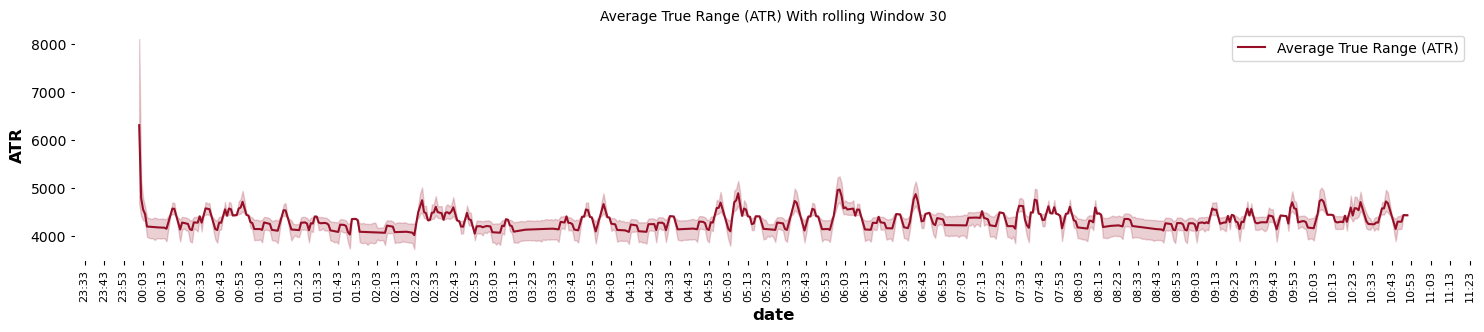

In [27]:
crypto_df['ATR'] = ATR(crypto_df, 30)

plt.figure(figsize=(18, 3))
crypto_df_reset = crypto_df.iloc[:5000, :].reset_index()
sns.lineplot(data=crypto_df_reset,x= 'date', y='ATR', label='Average True Range (ATR)', color=RdBu_colors[0], linewidth=1.5);

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
plt.xticks(rotation=90, fontsize = 8)
plt.title('Average True Range (ATR) With rolling Window 30', fontsize=10)
plt.grid(False)
plt.show()

## 7. Seasonal and Trend Decomposition
Breaking down a time series into three systematic components: trend-cycle, seasonal variation, and random fluctuations. 
- The trend component represents the long-term direction of the time series, which can be increasing, decreasing, or stable over time. 
- The seasonal component represents the recurring patterns that occur within the time series, such as yearly or quarterly cycles. 
- The random fluctuations component represents the random noise in the data that cannot be explained by the trend or seasonal components.

$$Y_t = T_t + S_t + E_t$$

- $Y_t$ represents the observed value at time t.
- $T_t$ represents the trend component at time t.
- $S_t$ represents the seasonal component at time t. 
- $E_t$ represents the residual component at time t.

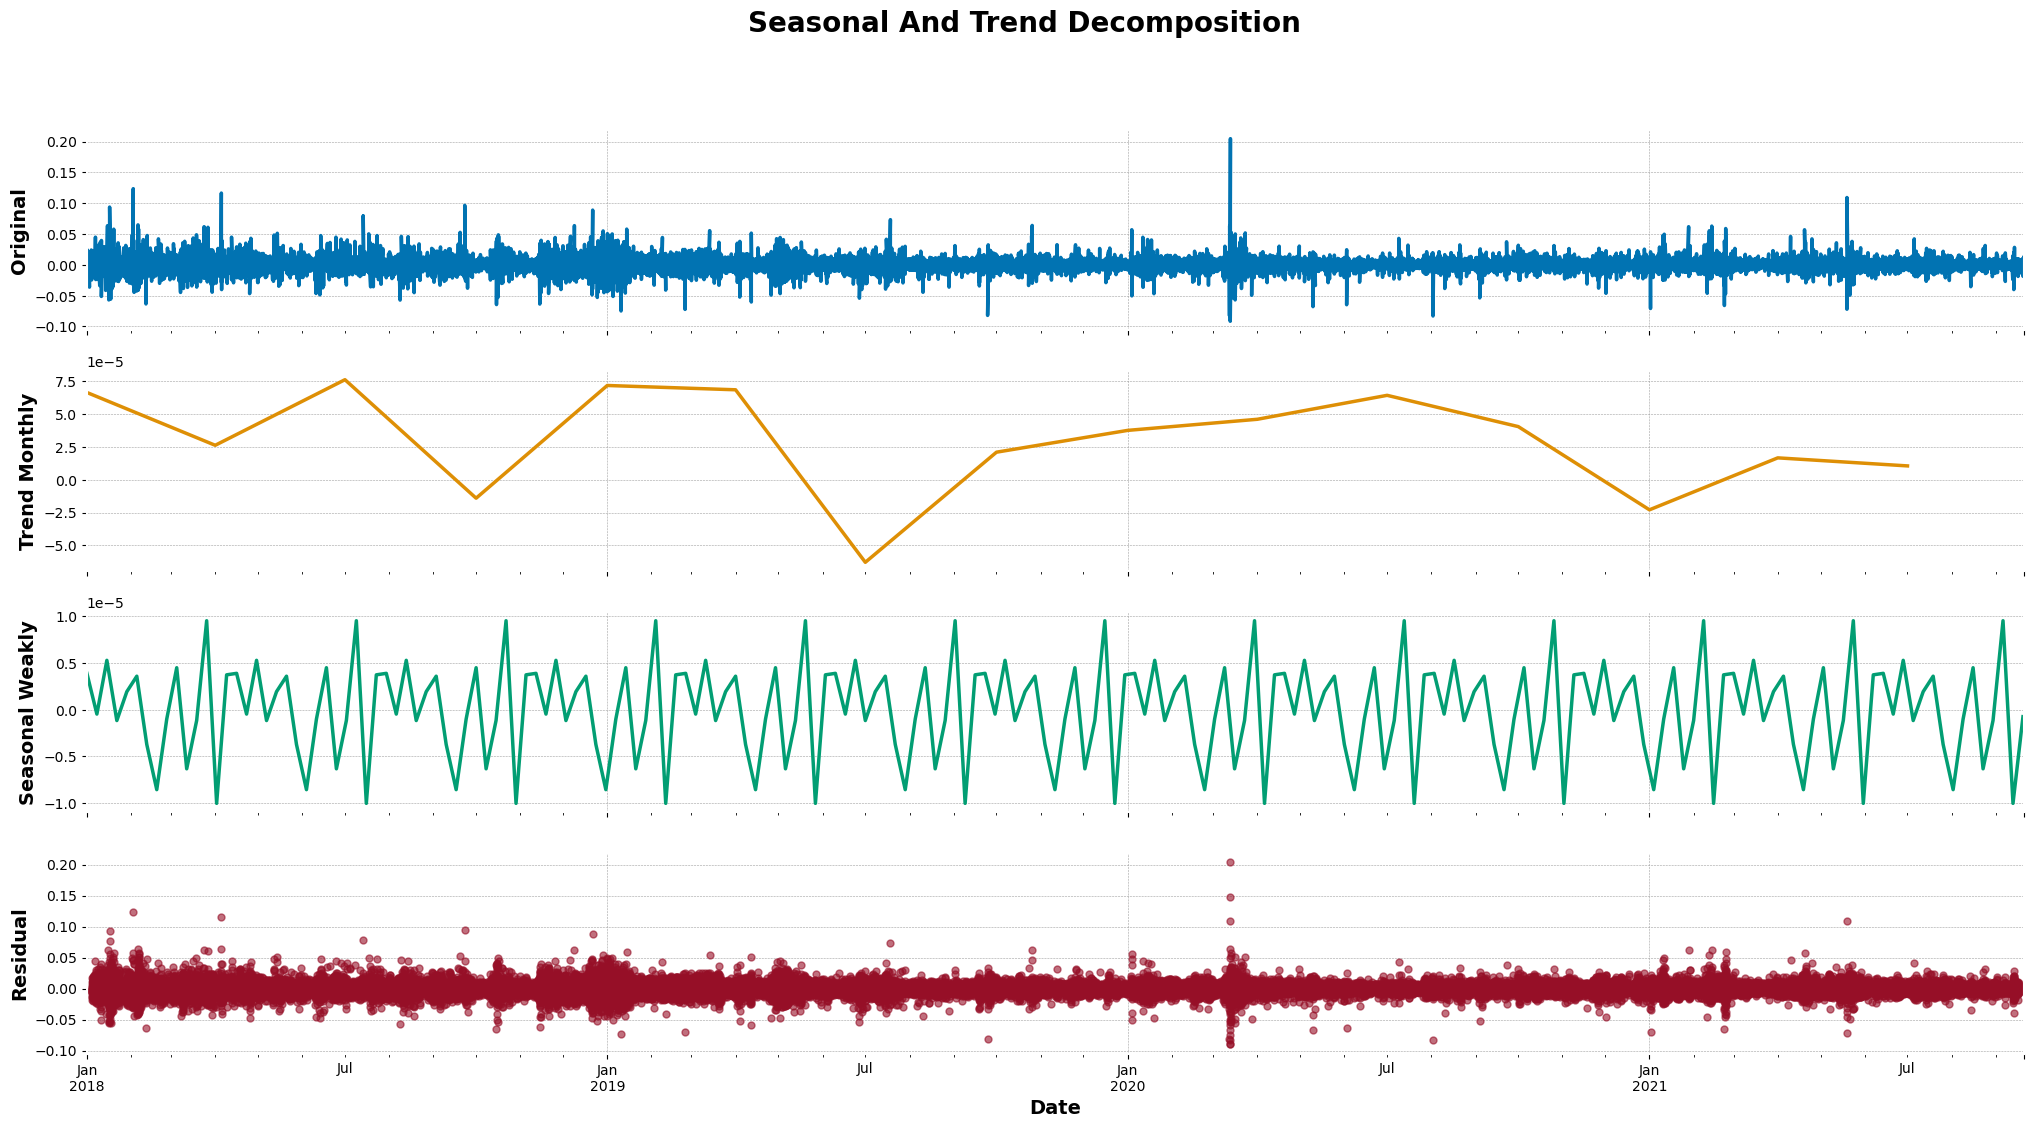

In [28]:
aggs = {'Count': 'sum', 'Open':'last', 'High':'last', 'Low':'last', 'Close':'last',
       'Volume':'mean', 'VWAP': 'mean', 'Target':'last'}

df_subset = crypto_df.resample('15T').agg(aggs)

result = seasonal_decompose(df_subset['Target'], model='additive', period=24*30) # weakly
PlotDecomposation(df_subset['Target'], result)

<a ><font size="2.5"><b>OBSERVATION:</b></font></a>

- As seasonal is a repeating pattern over fixed periods, this cause the trend to fluctuate up and down as the seasonal effects interact with the overall trend.
- A recognizable pattern in the residuals, but we will check the autocorrelations using Ljung-Box test.
- We want the residuals to be i.i.d (uncorrelated). If the residuals have a pattern, it means there is still some structural information left to be captured. 

**Ljung-Box Staticl test for Residual:** The Ljung-Box test is a statistical test used to determine whether a set of autocorrelations of a time series are different from zero based on the Q statistic. The Q statistic is a measure of the sum of squared autocorrelations of the residuals up to a certain lag.

In [56]:
resid = result.resid.dropna()
ljung = sm.stats.acorr_ljungbox(resid, return_df=True)
ljung_p_val = np.mean(ljung.iloc[:,1]).round(3)
print("P value=", ljung_p_val, ", Residuals are uncorrelated, there is no pattern" if ljung_p_val > 0.05 else ", Residuals are correlated")

P value= 0.718 , Residuals are uncorrelated, there is no pattern


<a ><font size="2.5"><b>OBSERVATION:</b></font></a>
Based on this p-value, we have strong evidence of significant serial correlation in the residuals. We can perform transformations to see if it stabilizes the variance. 

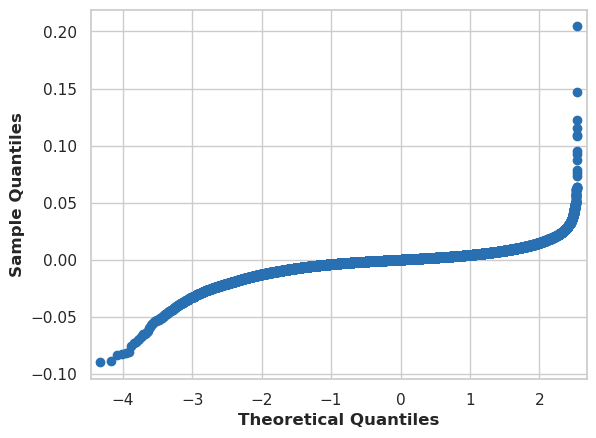

In [29]:
sns.set_theme(style="whitegrid", palette=RdBu_colors[-2:])
sm.qqplot(result.resid, line='s');

## 8. ACF and PACF
A stationary process is much more predictable than a non-stationary process. For the series to be stationary, it must have:
- Constant mean.
- Constant variance.
- Constant covariance (uncorrelated).
- No Seasonality.

We verify this by observing change in mean, variance, autocorrelation and with a statistical test (Auller test)

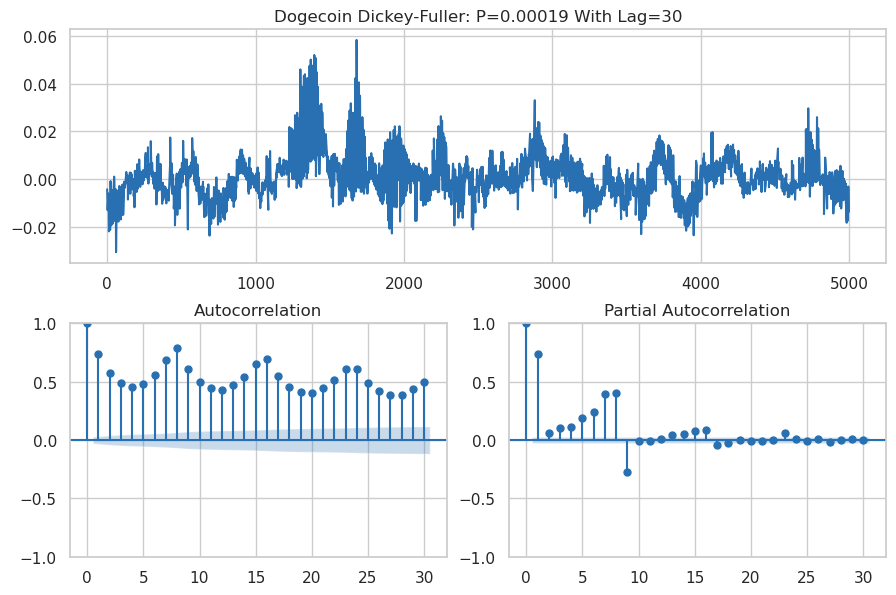

In [30]:
df = crypto_df[:5000]
result = exponential_smoothing(df['Target'], 0.5)
ACF_PACF(result, lags=30, name=i)

In [23]:
crypto_df.index = crypto_df['timestamp']

---
# (3) Feature Engineering

---

### 1: Technical Indicators Calculation
Calculating three essential technical indicators for each cryptocurrency asset: Relative Strength Index (RSI), Average True Range (ATR), and Double Exponential Moving Average (DEMA). 
> These indicators provide valuable insights into the asset's price momentum, volatility, and potential trend reversal points.

### 2: Lag Features Calculation
Calculate two lag features for each asset: Simple Moving Average (SMA) and Returns. 
> These features are valuable in capturing the asset's price trends over a specific period.

### 3: New Price-based Features

- **HL (High-Low):** The log of the difference between the 'High' and 'Low' prices, indicating the price range.
- **OC (Open-Close):** The log of the difference between the 'Close' and 'Open' prices, capturing the daily price changes.

- **Lower Shadow and Upper Shadow:** The log of the lengths of the lower and upper shadows of the candlesticks.

### 4: Datetime Features
Extract various datetime features from the 'timestamp' column, including:

- Day of the Week: The 'Day' feature represents the day of the week.
- Day of the Year: The 'dayofyear' feature represents the day of the year.
- Season of the Year: The 'season' feature categorizes the month into different seasons.

> These datetime features might reveal patterns related to specific days, times of the year, or seasonality in cryptocurrency price movements.

In [22]:
def get_features(df, i):
    
    pbar = tqdm(total=22, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')        
    # Calculate technical indicators: RSI, ATR, and DEMA for different time periods (30, 120, 240 minutes)
    pbar.set_description(f"Create 22 Features for {i:<16} ")

    for i in [30, 120, 240]:
        df[f'RSI_{i}'] = RSI(df, i)
        pbar.update(1)
        df[f'ATR_{i}'] = ATR(df, i)
        pbar.update(1)
        df[f'DEMA_{i}'] = DEMA(df, i)
        pbar.update(1)
        
    for i in [30, 120, 240]:
        # Create lag features: SMA and returns for different time periods (30, 120, 240 minutes)
        df[f'SMA_{i}'] = df['Close'].rolling(i).mean()/df['Close'] -1
        pbar.update(1)
        df[f'return_{i}'] = df['Close']/df['Close'].shift(i) -1
        pbar.update(1)
    
    # Create new features: HL, OC, lower_shadow, upper_shadow    
    df['HL'] = np.log(df['High'] - df['Low'])
    pbar.update(1)
    df['OC'] = np.log(df['Close'] - df['Open'])
    pbar.update(1)
    df['lower_shadow'] = np.log(lower_shadow(df)) 
    pbar.update(1)
    df['upper_shadow'] = np.log(upper_shadow(df))
    pbar.update(1)
    # replace inf with nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Extract datetime features: Day of the week (Day), day of the year (dayofyear), and season of the year (season)
    df['Date'] = pd.to_datetime(df['timestamp'], unit='s')
    df['Day'] = df['Date'].dt.weekday.astype(np.int32)
    pbar.update(1)
    df["dayofyear"] = df['Date'].dt.dayofyear
    pbar.update(1)
    df["season"] = ((df['Date'].dt.month)%12 + 3)//3
    pbar.update(1)
    
    df = df.drop(['Open','Close','High','Low', 'Volume', 'Date'], axis=1)
    
    # fill nan values with 0
    df = df.fillna(0)
    pbar.close()
    return df

#### **Prepare crypto_m1 dataset**
Iterate through each cryptocurrency asset one by one, ensuring 60-second intervals, perform feature engineering steps, then concatenate the processed data into the final `crypto_m1` DataFrame. 

In [24]:
start_time = time.time()
crypto_m1 = pd.DataFrame()

for i in asset_names:
    ##### For each asset #####
    feat_df = crypto_df[crypto_df.Asset_Name==i]
    # 1. Reformat the data to remove gaps, ensuring 60-second intervals
    feat_df = feat_df.reindex(range(feat_df.index[0], feat_df.index[-1] + 60, 60), method='pad')
    # 2. Perform feature engineering using the get_features function
    feat_df = get_features(feat_df, i)
    ##### Concate this asset #####
    crypto_m1 = pd.concat([crypto_m1,feat_df], axis = 0)
print('Total Elapse Time: {:0.2f} sec'.format(time.time() - start_time) )

Create 22 Features for Dogecoin         : 100%|██████████| 22/22 [00:02<00:00]


Total Elapse Time: 53.38 sec


In [25]:
# Add the 'Asset_ID' column to the DataFrame using asset_details DataFrame through a merge operation
crypto_m1 = pd.merge(crypto_m1, asset_details, how='left', on=['Asset_Name'])
crypto_m1['date'] = pd.to_datetime(crypto_m1['timestamp'], unit='s')
crypto_m1.set_index('date', inplace = True)

#### **Save prepared dataset**

In [46]:
crypto_m1.to_csv('./test/crypto_m1.csv')

---
# (4) Create cryptoh1 dataset

---

### Aggregation and Resampling
Aggregate dataset to create new version (hourly sample version). Iterate over the asset groups (14 groups in this case) and perform the aggregation and resampling operations.
For each asset group:
1. Take Only the data for `2021` as a sample.
2. Resample function to convert the data from one-minute intervals to hourly intervals ('H'). During 
3. Aggragte the features, the 'Count' values are summed, and some other variables are averaged. The rest features used the 'last' value.

In [26]:
aggs = {'Count': 'sum', 'VWAP': 'median', 'Day': 'median', 'dayofyear': 'median', 'season': 'median'}

features = ['RSI_30','ATR_30', 'DEMA_30', 'RSI_120', 'ATR_120', 'DEMA_120', 'RSI_240',
           'ATR_240', 'DEMA_240', 'SMA_30', 'return_30', 'SMA_120', 'return_120',
           'SMA_240', 'return_240', 'HL', 'OC', 'lower_shadow', 'upper_shadow', 'Asset_ID','Target']

for feature in features:
    aggs[feature] = 'last'

In [27]:
sample = crypto_m1[crypto_m1.index.year == 2021]
crypto_h1 = pd.DataFrame()

pbar = tqdm(total=14, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')        
for i in asset_names:
    pbar.set_description(f"Resample {i:<16} ")
    df = sample[sample.Asset_Name==i]
    df_hourly = df.resample('H').agg(aggs)
    df_hourly.reset_index(inplace=True)
    crypto_h1 = pd.concat([crypto_h1,df_hourly], axis = 0)
    pbar.update(1)
pbar.close()

Resample Dogecoin         : 100%|██████████| 14/14 [00:05<00:00]


In [28]:
reduce_memory(crypto_h1);

Memory taken before transformation :  16615816
Memory taken after transformation :  10959368
Memory taken reduced by :  34.04255319148936 %


#### **Quick Time Series Analysis after aggregation**

In [168]:
check_stationarity(crypto_h1['Target'])

    Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
ADF Statistic: -35.752450
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


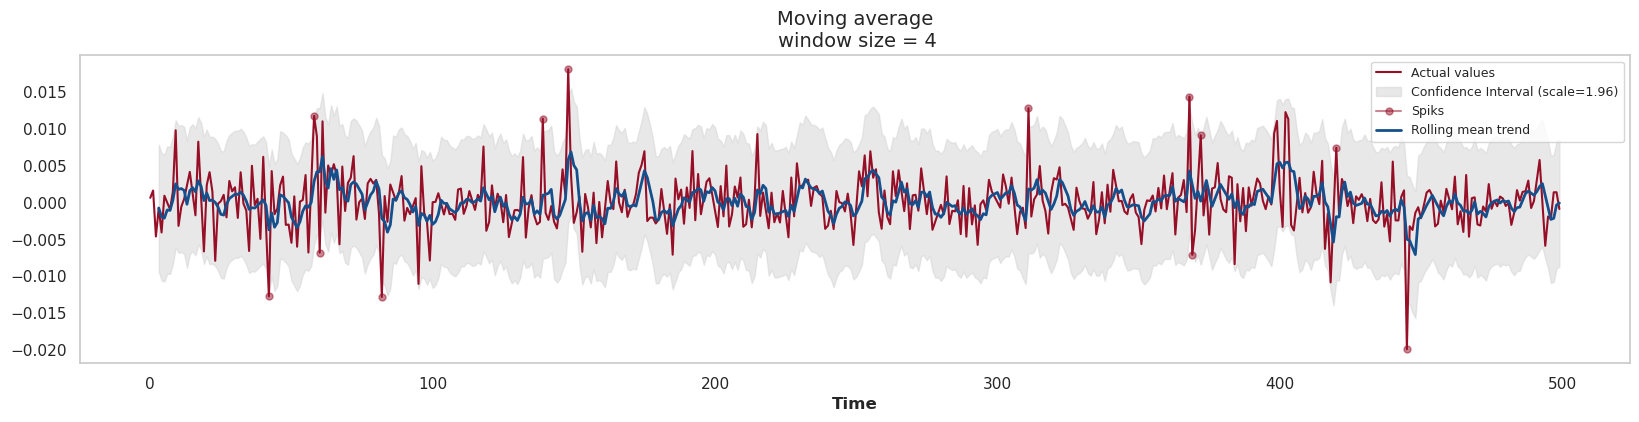

In [45]:
MovingAveragePlot(crypto_h1.iloc[:500, -1], window=4, plot_intervals=True, plot_anomalies=True, figsize=(20, 4))

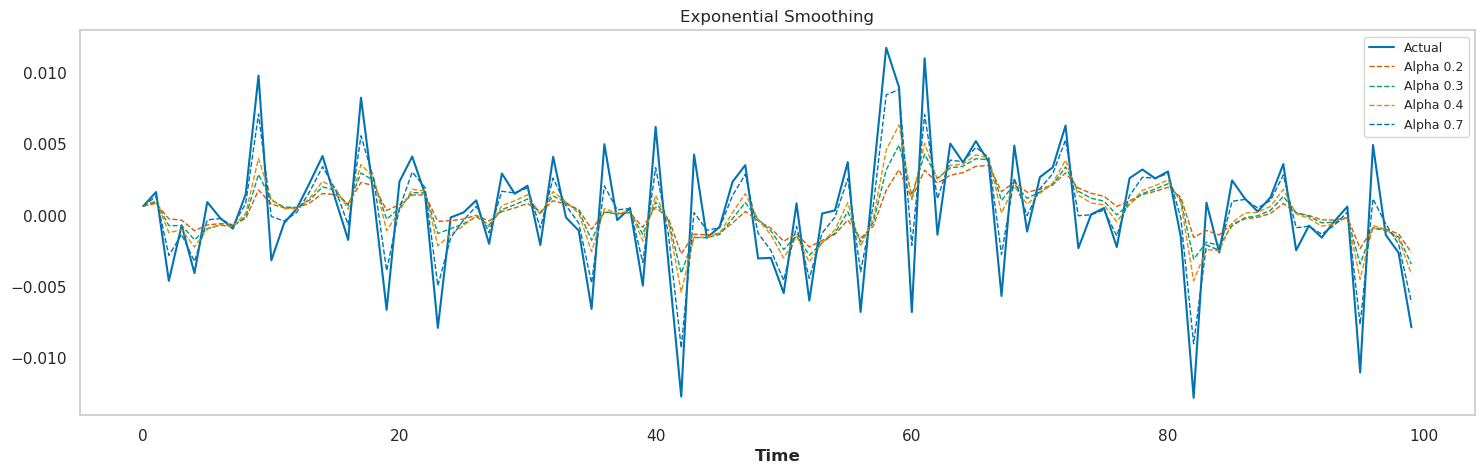

In [51]:
ExponentialSmoothingPlot(crypto_h1.iloc[:100,-1], alphas=[0.2, 0.3, 0.4, 0.7])

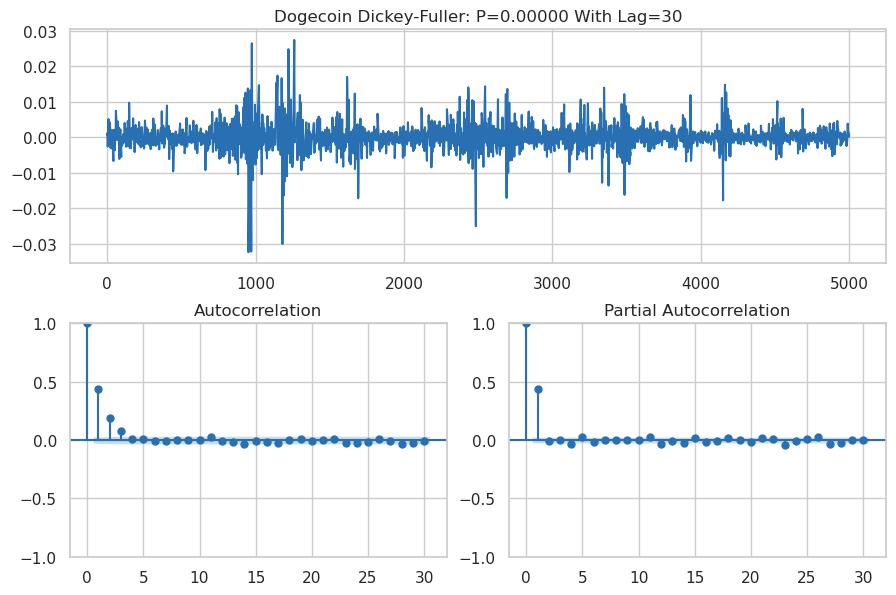

In [52]:
df = crypto_h1[:5000]
result = exponential_smoothing(df['Target'], 0.5)
ACF_PACF(result, lags=30, name=i)

In [48]:
# I will drop the datatime columns as the tranformers models create these feature while preparing the dataset
tmp = crypto_h1.drop(['Day', 'dayofyear'], axis = 1)
tmp.to_csv('./Datasets/CustomData/crypto_h1.csv', index = None)

---
<h1 style="text-align:center;">Modeling Hourly Cryptocurrancy Dataset</h1>

---

In [12]:
crypto_h1=pd.read_csv('./Datasets/CustomData/crypto_h1.csv', index_col = 0)
crypto_h1.shape

(88382, 24)

In [30]:
crypto_h1.head(2)

date       Count    VWAP    Day  dayofyear  season  RSI_30   
0 2021-01-01 00:00:00 10,303.0000 37.1139 4.0000     1.0000  1.0000 78.2651  \
1 2021-01-01 01:00:00 13,708.0000 37.6214 4.0000     1.0000  1.0000 44.5080   

   ATR_30  DEMA_30  RSI_120  ATR_120  DEMA_120  RSI_240  ATR_240  DEMA_240   
0  0.0552  37.3281  52.7928   0.0553   37.2137  51.8431   0.0507   37.1948  \
1  0.0783  37.6910  53.8778   0.0683   37.6640  54.3513   0.0582   37.5128   

   SMA_30  return_30  SMA_120  return_120  SMA_240  return_240      HL     OC   
0 -0.0048     0.0089  -0.0048      0.0043  -0.0061      0.0055 -3.0180 0.0000  \
1  0.0027    -0.0033  -0.0059      0.0074  -0.0088      0.0148 -3.3410 0.0000   

   lower_shadow  upper_shadow  Asset_ID  Target  
0       -4.5756       -4.5657         2  0.0007  
1       -3.8777       -4.7914         2  0.0016

#### **Take Sample for testing**

In [37]:
pred_len = 96 
sample = 10000

Xtrain, ytrain = crypto_h1.iloc[-sample:-pred_len,1:-1] , crypto_h1.iloc[-sample:-pred_len,:-1]
Xtest, ytest = crypto_h1.iloc[-pred_len:,1:-1] , crypto_h1.iloc[-pred_len:,-1]

# Print the lengths of the training and testing sets
print("Training set length:", Xtrain.shape)
print("Testing set length:", Xtest.shape)

Training set length: (9904, 25)
Testing set length: (96, 25)


In [15]:
%%time
model = pm.auto_arima(ytrain, X = Xtrain,
                      m=12, seasonal=True, test='adf',error_action='ignore',  
                      start_p=3, start_q=1, max_order=8, maxiter=5,
                      suppress_warnings=True, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(3,0,1)(1,0,1)[12] intercept   : AIC=-77848.589, Time=170.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-77845.871, Time=115.90 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-77844.186, Time=144.91 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-77844.053, Time=145.31 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3372.807, Time=111.18 sec
 ARIMA(3,0,1)(0,0,1)[12] intercept   : AIC=-77850.640, Time=159.52 sec
 ARIMA(3,0,1)(0,0,0)[12] intercept   : AIC=-77852.423, Time=133.77 sec
 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=-77850.637, Time=165.82 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-77855.301, Time=130.18 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=-77853.518, Time=180.21 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-77851.472, Time=187.41 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-77843.367, Time=126.68 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-77853.439, Time=127.70 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept  

In [27]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9904
Model:               SARIMAX(2, 0, 1)   Log Likelihood               38955.648
Date:                Sat, 22 Jul 2023   AIC                         -77857.296
Time:                        12:59:36   BIC                         -77662.877
Sample:                             0   HQIC                        -77791.455
                               - 9904                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Count        -8.047e-09   1.19e-09     -6.766      0.000   -1.04e-08   -5.72e-09
VWAP            -0.2532      0.002   -159.892      0.000      -0.256      -0.250
season           0.0001   7.09e-05      1.43


Forecasting Results: RMSE= 0.004504689998379294, MAE= 0.003287943470098072, %MAPE= 1.1731188839559301%



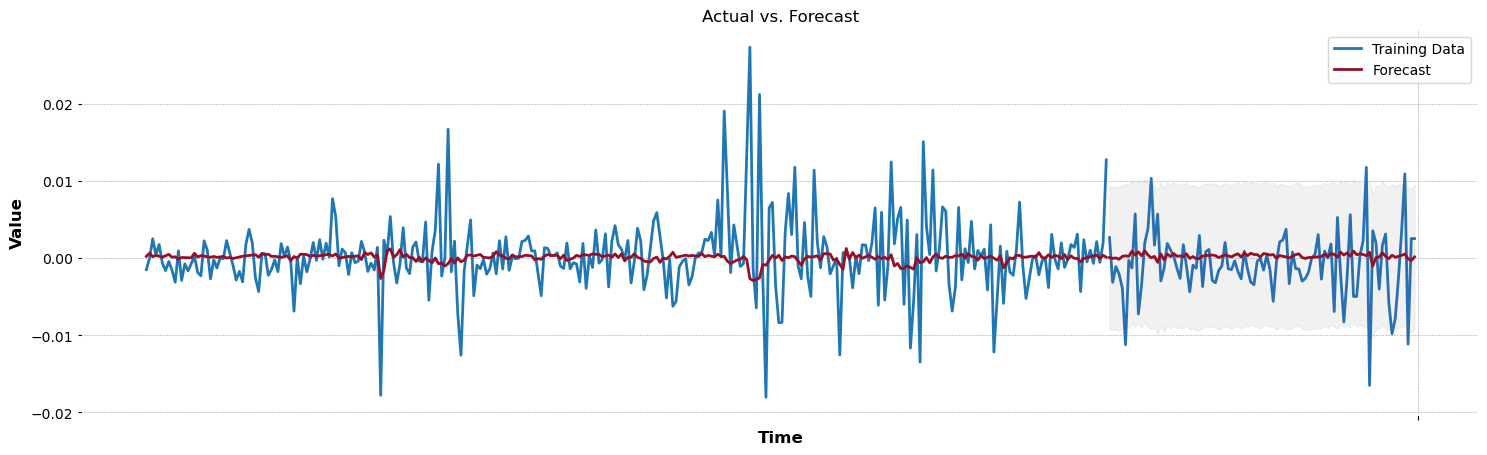

In [73]:
InteractiveShell.ast_node_interactivity = 'last_expr'
forecast, conf_int = model.predict(n_periods=pred_len, X=Xtest, return_conf_int=True)
train_forcast = model.predict(n_periods=plot_sample, X=Xtrain.iloc[-plot_sample:,:])

errors= [rmse(ytest, forecast), 
         mean_absolute_error(ytest, forecast), 
         mean_absolute_percentage_error(ytest, forecast)]
print("\nForecasting Results: RMSE= {}, MAE= {}, %MAPE= {}%\n".format(errors[0], errors[1], errors[2]))

plot_sample=300

plt.figure(figsize=(18, 5))
plt.plot(ytrain[-plot_sample:], label='Training Data')
plt.plot(ytest, color=RdBu_colors[-2])
plt.plot(range(0, plot_sample), train_forcast, label='Forecast', color=RdBu_colors[0])

plt.plot(range(len(ytrain[-plot_sample:]), len(ytrain[-plot_sample:]) + len(forecast)), forecast, color=RdBu_colors[0])
plt.axvspan(range(len(ytrain[-plot_sample:]), len(ytrain[-plot_sample:]) + len(forecast)), plot_sample, color='lightgray', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Forecast')
plt.legend()
plt.xticks('',rotation=90)
plt.show()

#### **Data Normalization**

In [39]:
crypto_h1['date'] = pd.to_datetime(crypto_h1['date'])  # Convert to pandas Timestamp objects
crypto_h1.set_index('date', inplace = True)

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = crypto_h1.drop([ 'Target', 'Day','dayofyear','season', 'Asset_ID'], axis = 1)
y = crypto_h1.Target

X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [41]:
X_scaled_df.index = crypto_h1.index
X_scaled_df = pd.concat([X_scaled_df, crypto_h1[['Day','dayofyear','season', 'Asset_ID']]], axis = 1)
X_scaled_df.reset_index(inplace = True);
X_scaled_df = X_scaled_df.drop('date', axis=1)
X_scaled_df.head(2)

Count    VWAP  RSI_30  ATR_30  DEMA_30  RSI_120  ATR_120  DEMA_120   
0 -0.4719 -0.3101  2.3372 -0.2610  -0.3100   0.4245  -0.2712   -0.3100  \
1 -0.4284 -0.3100 -0.5031 -0.2605  -0.3100   0.6106  -0.2709   -0.3100   

   RSI_240  ATR_240  DEMA_240  SMA_30  return_30  SMA_120  return_120   
0   0.3885  -0.2782   -0.3100 -0.6927     0.6958  -0.3401      0.1460  \
1   1.0059  -0.2781   -0.3100  0.3974    -0.2839  -0.4197      0.2737   

   SMA_240  return_240      HL     OC  lower_shadow  upper_shadow    Day   
0  -0.3107      0.1202 -0.1752 0.5778       -0.2938       -0.2949 4.0000  \
1  -0.4491      0.3992 -0.2563 0.5778       -0.1198       -0.3511 4.0000   

   dayofyear  season  Asset_ID  
0     1.0000  1.0000         2  
1     1.0000  1.0000         2

---
### 1. Choosing ARIMA as a basline model.

Choosing the Autoregressive Integrated Moving Average (ARIMA) model as the baseline time series forecasting model from the traditional models. 

In [1]:
# def Traning_ARIMA(X=None, y=None, pred_len=10, n_plot=100, alpha=0.3):

#     # Calculate exponential smoothing
#     print(f"> Smoothing with alpha: {alpha}")
    
#     smoothed_X = pd.DataFrame()
#     for column in X.columns:
#         smoothed_X[column] = exponential_smoothing(X[column], alpha)
    
#     smoothed_y = exponential_smoothing(y, alpha)
#     y = np.array(y)
#     Xtrain, ytrain = smoothed_X.iloc[:-pred_len, :], smoothed_y[:-pred_len]
#     Xtest, ytest = smoothed_X.iloc[len(y)-pred_len:, :], smoothed_y[len(y)-pred_len:]
#     # Training
#     print(f"> Training ", end='')
#     start_time=time.time()
#     model = pm.auto_arima(ytrain, X=Xtrain, maxiter=5, test='adf',seasonal=True,
# #                           start_p=1, start_q=0, max_p=3, max_d=2, max_q=1, m=7,
#                           start_p=4, start_q=3, max_p=5, max_d=1, max_q=5, m=7,
#                           suppress_warnings=True, stepwise=True, trace=True) #
    
#     print("\nTraining Summeray:", model.summary(),'\n')
#     print("Training Time = {} mins\n".format((time.time()-start_time)/60.0))
#     print('Model Parameters :' , model.params)
    
#     # Forecasting
#     print(f"> Evaluating ",end='')

#     start_time = time.time()
#     forecast, conf_int = model.predict(n_periods=pred_len, X=Xtest, alpha=alpha, return_conf_int=True)
#     errors= [rmse(ytest, forecast), mean_absolute_error(ytest, forecast), mean_absolute_percentage_error(ytest, forecast)]
#     print("\nForecasting Results: RMSE= {}, MAE= {}, %MAPE= {}%, Testing Time = {} mins\n".format(errors[0], errors[1], errors[2], time.time()-start_time))

#     # Plot results 
#     plt.figure(figsize=(16, 4))
#     plt.axvspan(n_plot-pred_len, n_plot, alpha=0.5, color='lightgrey')
#     plt.plot(y[len(y)-n_plot:], label="Actual")
#     plt.fill_between(range(n_plot-pred_len, n_plot), conf_int[:, 0], conf_int[:, 1], color=pastel_colors[0], alpha=0.5, label='Confidence Interval')
#     plt.plot(range((n_plot-pred_len), n_plot), np.array(forecast), color = RdBu_colors[0], label="Model")
#     plt.legend()
#     plt.grid(True);
#     plt.show()

In [51]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

def Traning_ARIMA(X=None, y=None, pred_len=10, n_plot=100, p=2, q=1, d=0, alpha=0.6):

    # Calculate exponential smoothing
    print(f"> Smoothing with alpha: {alpha}")
    
    smoothed_X = pd.DataFrame()
    for column in X.columns:
        smoothed_X[column] = exponential_smoothing(X[column], alpha)
    
    smoothed_y = exponential_smoothing(y, alpha)
    y = np.array(y)
    Xtrain, ytrain = smoothed_X.iloc[:-pred_len, :], smoothed_y[:-pred_len]
    Xtest, ytest = smoothed_X.iloc[len(y)-pred_len:, :], smoothed_y[len(y)-pred_len:]
    
    # Training
    print(f"> Training ", end='')
    start_time = time.time()
    order = (p, 0, q)  # Set the (p, d, q) order manually based on your best ARIMA model selection
    model = ARIMA(endog=ytrain, exog=Xtrain, order=order)
    model = model.fit()
    
    print("\nTraining Summary:")
    print(model.summary())
    print("Training Time = {} mins\n".format((time.time()-start_time)/60.0))
    
    # Forecasting
    print(f"> Evaluating ",end='')
    
    start_time = time.time()
    forecast = model.predict(start=0, end=pred_len)
    errors= [rmse(ytest, forecast), mean_absolute_error(ytest, forecast), mean_absolute_percentage_error(ytest, forecast)]
    print("\nForecasting Results: RMSE= {}, MAE= {}, %MAPE= {}%, Testing Time = {} mins\n".format(errors[0], errors[1], errors[2], time.time()-start_time))
    
    return forecast, model, errors

In [ ]:
%%time
    
p = 2
q = 1
alpha = 0.5

pred_len = 96 
n_plot = 300

Traning_ARIMA(X_scaled_df, y,  pred_len, n_plot, p=2, q=1, d=0, alpha=0.6)

> Smoothing with alpha: 0.6
> Training 
Training Summary:


In [ ]:
.

#### **Evaluting ARIMA by predicting 96 future values**

                                             Bitcoin                                                                                                                                                    
> Loading Bitcoin dataset

   Training Data Period = 49990 mins,     Testing Data Period = 10 mins,     Loading Time = 0.15 secs

> Smoothing
> Training 
   Training Results:     AIC = -508022.30,     Training Time = 1.80 mins

> Evaluating 
   Forecasting Results:   RMSE= 0.00,     MAE= 0.00,     %MAPE= 4.40%     Testing Time = 0.01 mins



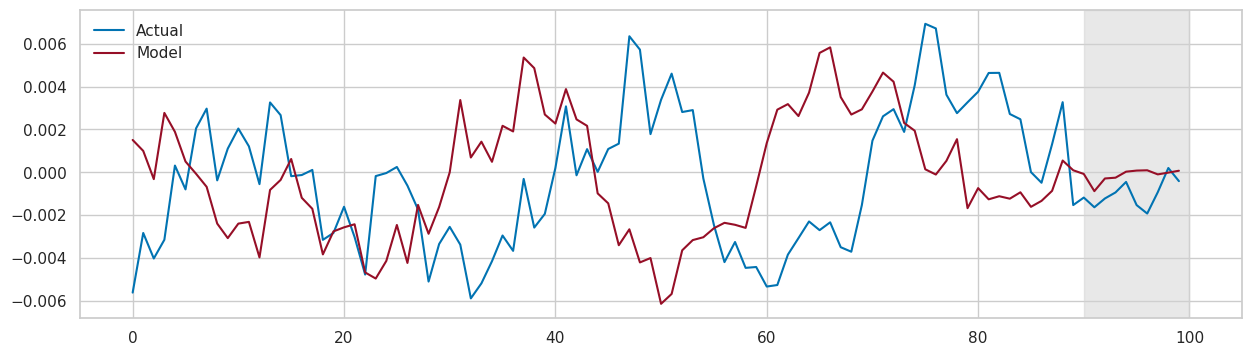

CPU times: user 4min 41s, sys: 19min 12s, total: 23min 54s
Wall time: 1min 48s


In [44]:
%%time
p = 0
q = 0
alpha = 0.5
pred_len = 96 
n_plot = 96 

Traning_ARIMA(X_scaled_df, y, pred_len, n_plot, alpha)

#### **Evaluting ARIMA by predicting 720 future values**

                                             Bitcoin                                                                                                                                                    
> Loading Bitcoin dataset

   Training Data Period = 49900 mins,     Testing Data Period = 100 mins,     Loading Time = 0.11 secs

> Smoothing
> Training 
   Training Results:     AIC = -507141.72,     Training Time = 2.08 mins

> Evaluating 
   Forecasting Results:   RMSE= 0.00,     MAE= 0.00,     %MAPE= 4.40%     Testing Time = 0.01 mins



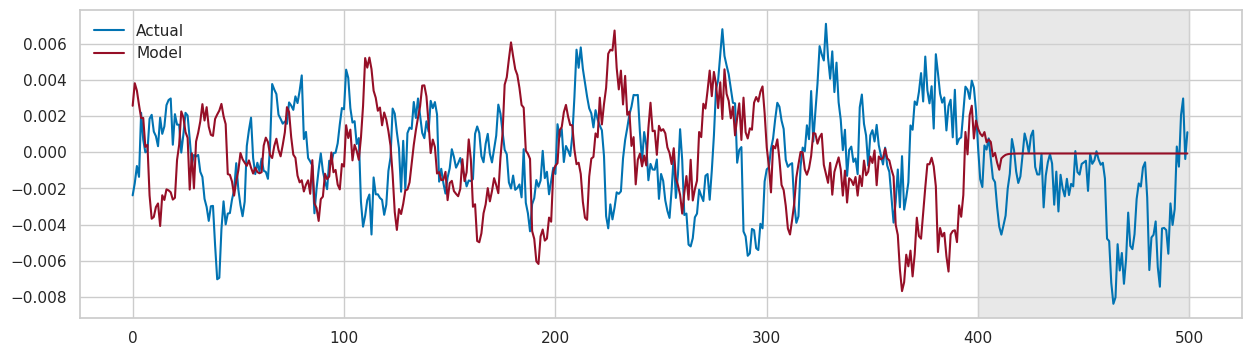

CPU times: user 5min 26s, sys: 22min 29s, total: 27min 56s
Wall time: 2min 4s


In [45]:
%%time
p = 0
q = 0
alpha = 0.5
pred_len = 720 
n_plot = 720 

Traning_ARIMA(X_scaled_df, y, pred_len, n_plot, alpha)

---
### 2. Evaluating the dataset DLinear


In [14]:
def Evaluate( model_name, pred_len, ax, colors):
    """
    Plots the predicted and true values for a given model and prediction horizon (pred_len).

    Args:
    model_name (str): The name of the model used to make predictions.
    pred_len (int): The length of the prediction horizon (i.e., the number of future values to predict).
    ax (matplotlib.axes.Axes): A Matplotlib Axes object on which to draw the plot.
    colors (List[str]): A list of two colors to use for the actual and predicted lines, respectively.
    
    """
    
    InteractiveShell.ast_node_interactivity = 'last_expr'
    
    setting = model_name+'_train_on_Bitcoin_'+str(pred_len)
    trues = np.load('./results/'+ setting +'/true.npy') # [samples, pred_len, dimensions]
    preds = np.load('./results/'+ setting +'/pred.npy') # [samples, pred_len, dimensions]
    mae, mse, rmse, mape, mspe = np.load('./results/'+ setting +'/metrics.npy', allow_pickle=True) 
#     print("Prediction labels shape: {}, Actual labels ahape:{}".format(preds.shape, trues.shape))
    print(setting + '\t: mae:{:0.2f}, mse:{:0.2f}, rmse:{:0.2f}, mape:{:0.2f}, mspe:{:0.2f}'.format(mae, mse, rmse, mape, mspe))
    
    for i, data in enumerate([trues[0,:,-1], preds[0,:,-1]]):
        sns.lineplot(x=range(len(data)), y=data, label=["Actual", model_name][i], color=colors[i], ax=ax)
    ax.set_title(f"{model_name} results of {pred_len} future values of `Target` column".title())
    ax.legend()

DLinear_train_on_Bitcoin_96	: mae:0.46, mse:0.41, rmse:0.64, mape:1.56, mspe:198.70
DLinear_train_on_Bitcoin_192	: mae:0.47, mse:0.43, rmse:0.66, mape:1.73, mspe:267.97
DLinear_train_on_Bitcoin_336	: mae:0.47, mse:0.44, rmse:0.66, mape:1.71, mspe:248.70
DLinear_train_on_Bitcoin_720	: mae:0.48, mse:0.45, rmse:0.67, mape:1.76, mspe:280.39


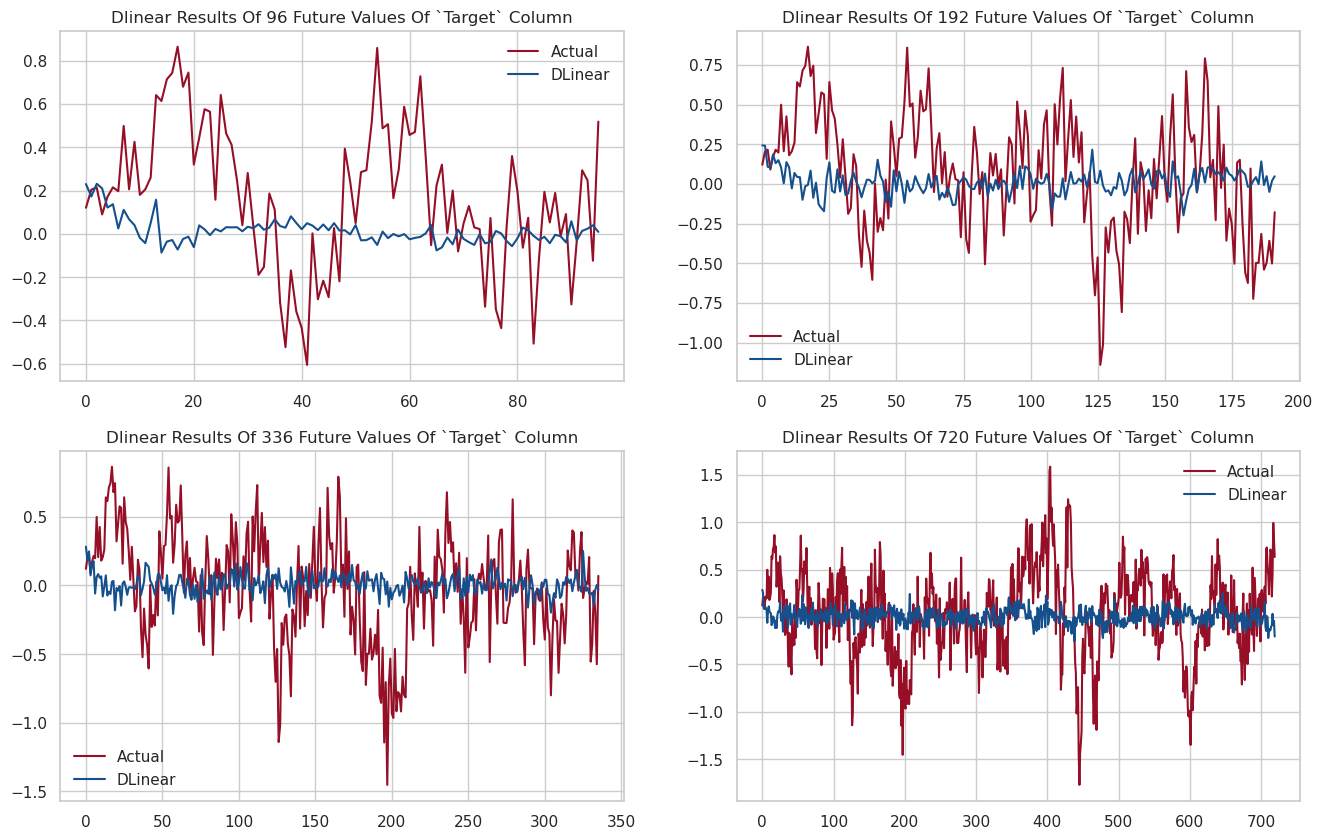

In [25]:
pred_lens = [96,192,336,720]
colors = [RdBu_colors[0], RdBu_colors[-1]]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate("DLinear", pred_len,ax, colors)

plt.show()

---
### 3. Evaluating the dataset NLinear

NLinear_train_on_Bitcoin_96	: mae:0.47, mse:0.43, rmse:0.66, mape:1.95, mspe:347.02
NLinear_train_on_Bitcoin_192	: mae:0.47, mse:0.44, rmse:0.66, mape:1.83, mspe:227.28
NLinear_train_on_Bitcoin_336	: mae:0.47, mse:0.44, rmse:0.67, mape:1.80, mspe:224.23
NLinear_train_on_Bitcoin_720	: mae:0.48, mse:0.45, rmse:0.67, mape:1.88, mspe:332.40


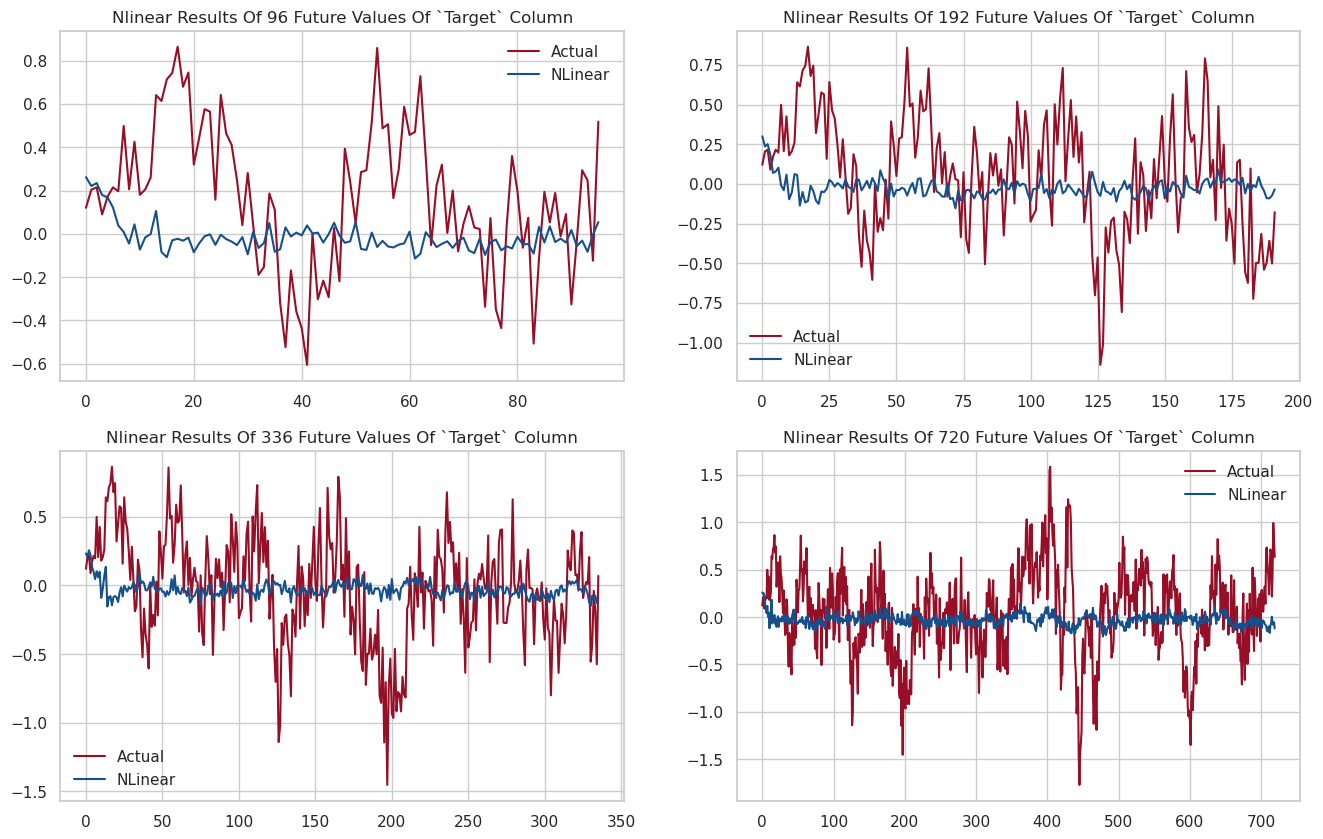

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate("NLinear", pred_len,ax, colors)

plt.show()

---
### 4. Evaluating the dataset Informer
 


informer_train_on_Bitcoin_96	: mae:0.42, mse:0.34, rmse:0.59, mape:1.62, mspe:864.93
informer_train_on_Bitcoin_192	: mae:0.42, mse:0.34, rmse:0.59, mape:1.46, mspe:412.14
informer_train_on_Bitcoin_336	: mae:0.42, mse:0.34, rmse:0.59, mape:1.42, mspe:364.67
informer_train_on_Bitcoin_720	: mae:0.42, mse:0.35, rmse:0.59, mape:1.66, mspe:1027.10


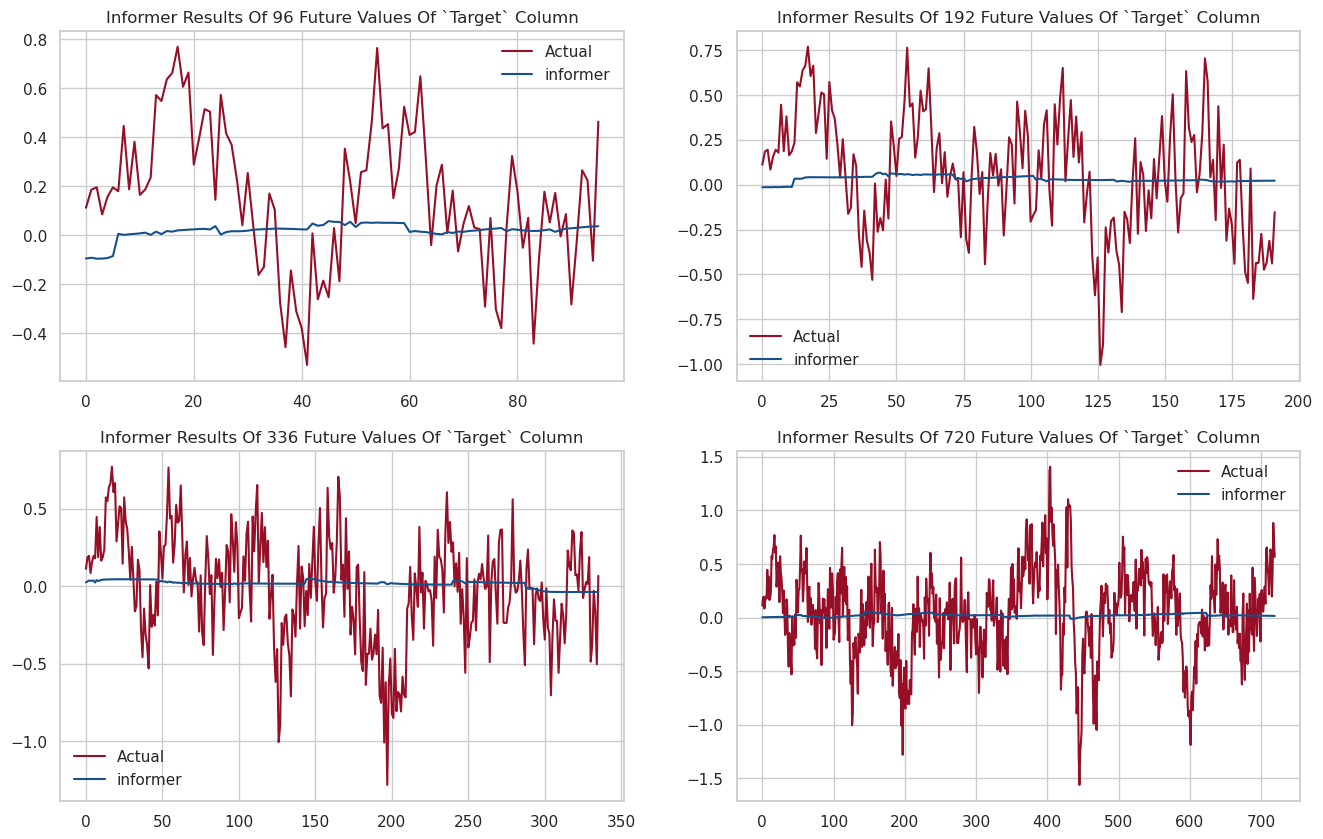

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate("informer", pred_len,ax, colors)

plt.show()

---
### 6. Evaluating the dataset FEDfromer


FEDformer_train_on_Bitcoin_96	: mae:1.39, mse:3.16, rmse:1.78, mape:31.84, mspe:1245519.50
FEDformer_train_on_Bitcoin_192	: mae:1.55, mse:3.79, rmse:1.95, mape:34.70, mspe:1438758.25
FEDformer_train_on_Bitcoin_336	: mae:1.57, mse:3.87, rmse:1.97, mape:34.67, mspe:1476521.12
FEDformer_train_on_Bitcoin_720	: mae:1.64, mse:4.21, rmse:2.05, mape:38.43, mspe:1740615.25


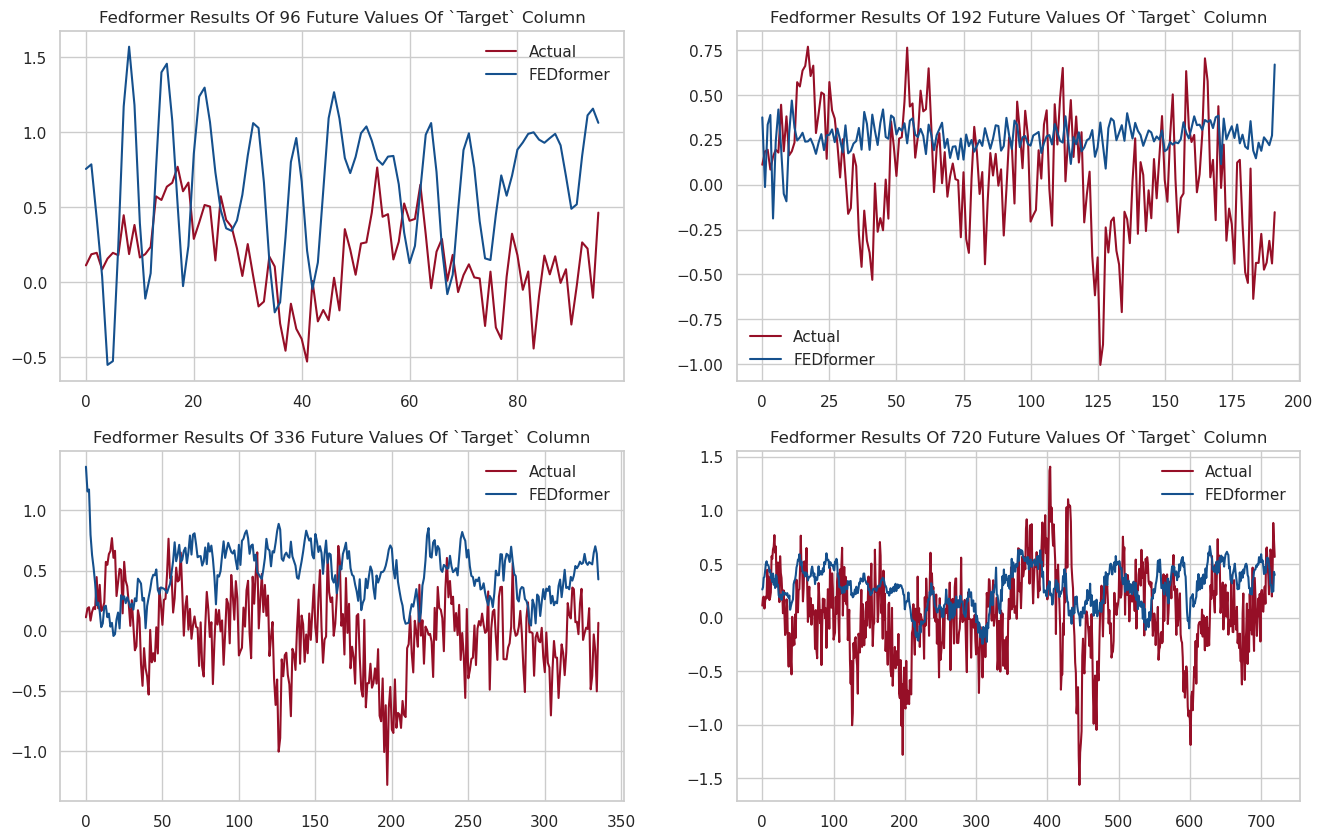

In [29]:
model_name = "FEDformer"
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate(model_name, pred_len, ax, colors)

plt.show()

---
### 6. Evaluating the dataset PathchTST

PatchTST_train_on_Bitcoin_96	: mae:0.42, mse:0.34, rmse:0.59, mape:1.97, mspe:1722.32
PatchTST_train_on_Bitcoin_192	: mae:0.42, mse:0.34, rmse:0.59, mape:1.94, mspe:1947.81
PatchTST_train_on_Bitcoin_336	: mae:0.42, mse:0.35, rmse:0.59, mape:1.99, mspe:1961.19
PatchTST_train_on_Bitcoin_720	: mae:0.42, mse:0.35, rmse:0.59, mape:1.70, mspe:994.00


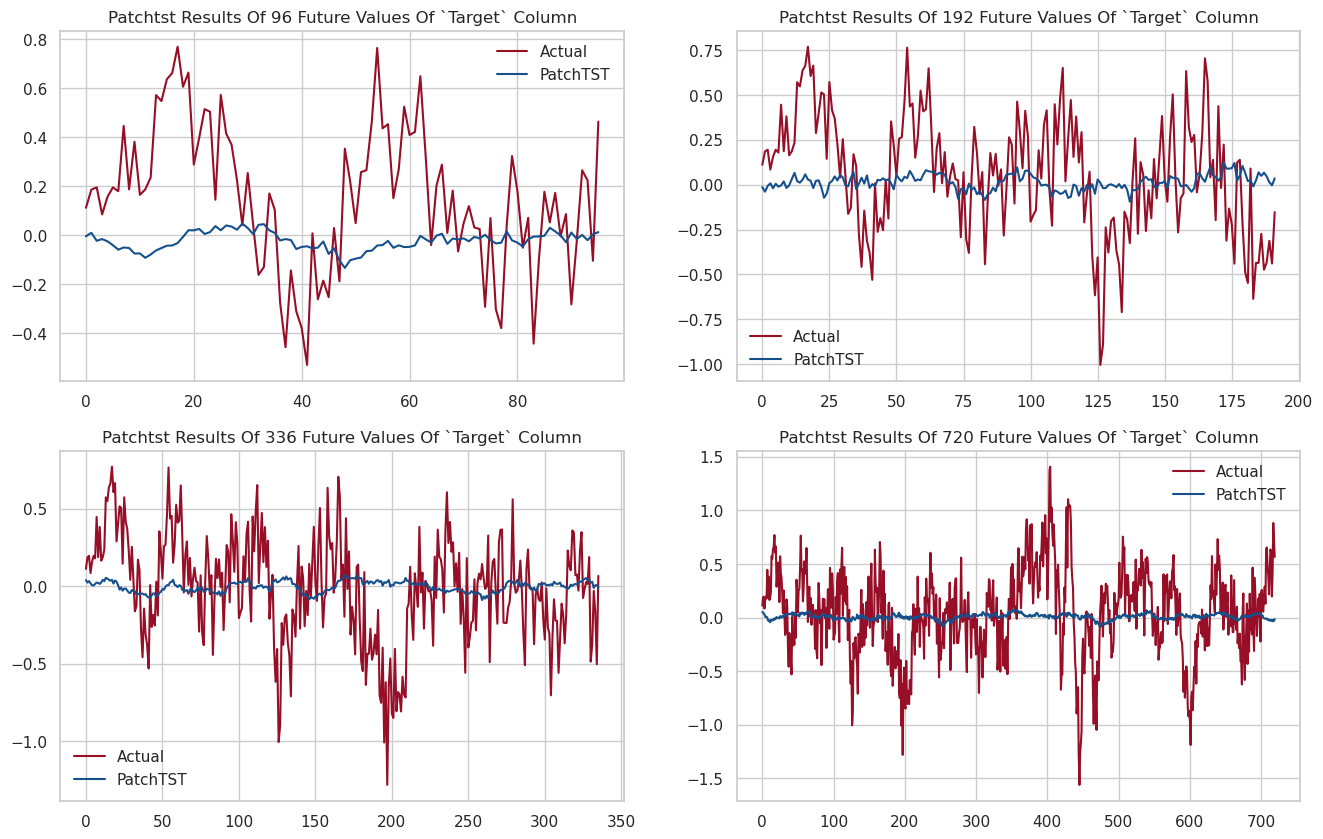

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
pred_lens = [96,192,336,720]

for i, pred_len in enumerate(pred_lens):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    Evaluate("PatchTST", pred_len,ax, colors)

plt.show()